In [1]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [2]:
import numpy as np
import time
import pickle
from pprint import pprint
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import numpy as np
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman
from lenstronomy.Util import data_util
from pandeia.engine.calc_utils import build_default_calc, build_default_source
from pandeia.engine.perform_calculation import perform_calculation
from tqdm import tqdm
from copy import deepcopy

from package.helpers.roman_params import RomanParameters
from package.pandeia import pandeia_input, pandeia_output
from package.pandeia.pandeia_output import PandeiaOutput
from package.plots import diagnostic_plot, plot, lens_plot
from package.helpers.lens import Lens
from package.helpers import pyhalo

plt.style.use(f'{repo_path}/package/mplstyle/science.mplstyle')

In [3]:
csv = os.path.join(repo_path, 'data', 'roman_spacecraft_and_instrument_parameters.csv')
array_dir = os.path.join(repo_path, 'output', 'arrays', 'skypy_test')
data_dir = os.path.join('/data','bwedig', 'roman-population', 'data')
figure_dir = os.path.join(repo_path, 'figures')
csv_path = os.path.join(data_dir, 'dictparaggln_Area00000010.csv')
df = pd.read_csv(csv_path)

In [4]:
index = 3
row = df.iloc[index]

lens = Lens(z_lens=row['redslens'], 
            z_source=row['redssour'], 
            sigma_v=row['velodisp'], 
            lens_x=row['xposlens'], 
            lens_y=row['yposlens'], 
            source_x=row['xpossour'], 
            source_y=row['ypossour'], 
            mag_lens=row['magtlensF106'], 
            mag_source=row['magtsourF106'])

# add CDM subhalos
lens.add_subhalos(*pyhalo.generate_CDM_halos(lens.z_lens, lens.z_source))

In [5]:
grid_oversample = 1

array = lens.get_array(num_pix=90 * grid_oversample, side=10.)

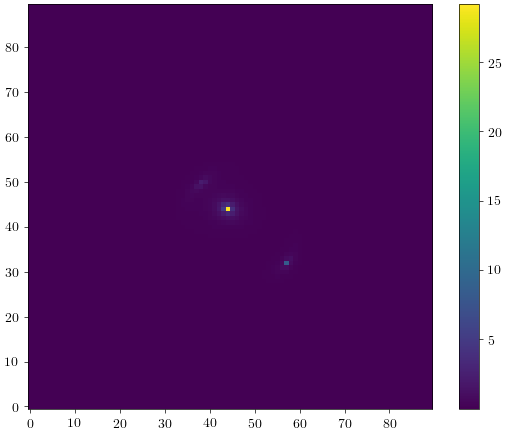

In [6]:
plot.plot(array, colorbar=True)

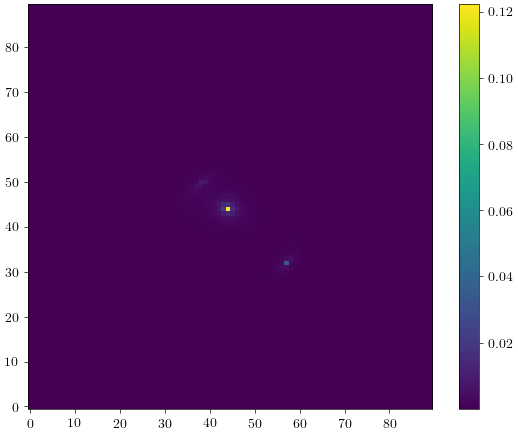

In [7]:
sum = np.sum(array)
normalized_array = array / sum

plot.plot(normalized_array, colorbar=True)

In [22]:
num_samples = 1000

source_flux_cps = lens.source_model_class.total_flux(lens.kwargs_source_amp)[0]
lens_flux_cps = lens.lens_light_model_class.total_flux(lens.kwargs_lens_light_amp)[0]

total_flux_cps = source_flux_cps + lens_flux_cps

counts_per_pixel = total_flux_cps / num_samples

In [23]:
# Create a flat copy of the array
flattened = normalized_array.flatten()

sample_indices = np.random.choice(a=flattened.size, p=flattened, size=num_samples)
adjusted_indices = np.unravel_index(sample_indices, normalized_array.shape)
adjusted_indices = np.array(list(zip(*adjusted_indices)))

In [24]:
reconstructed_array = np.zeros(array.shape)

for x, y in adjusted_indices:
    reconstructed_array[x][y] += counts_per_pixel

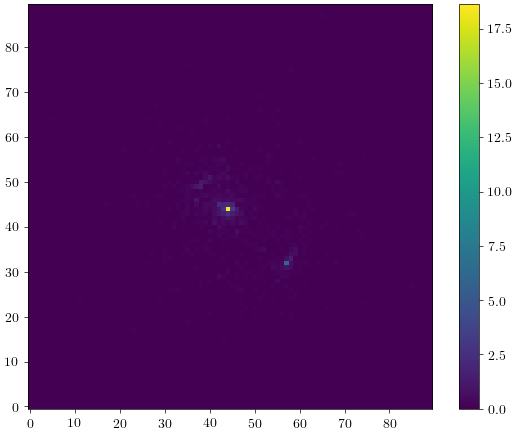

In [25]:
plot.plot(reconstructed_array, colorbar=True)

In [26]:
band = 'f106'

mag_array = pandeia_input._convert_cps_to_magnitude(reconstructed_array, band)

100%|██████████| 90/90 [00:00<00:00, 3143.13it/s]


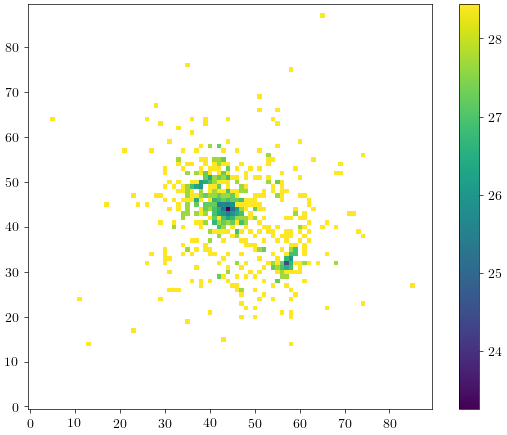

In [27]:
plot.plot(mag_array, colorbar=True)

100%|██████████| 90/90 [00:00<00:00, 11148.47it/s]


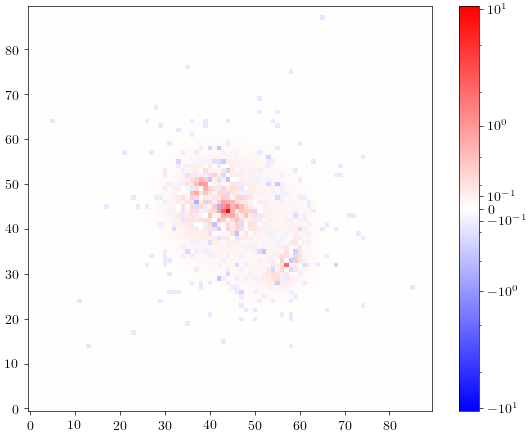

In [28]:
mag_to_counts_array = pandeia_input._convert_magnitude_to_cps(mag_array, band)

diagnostic_plot.residual(array, reconstructed_array)

In [29]:
calc = build_default_calc('roman', 'wfi', 'imaging')

# set scene size settings
# calc['configuration']['dynamic_scene'] = True
calc['configuration']['max_scene_size'] = 5

# set filter
calc['configuration']['instrument']['filter'] = band.lower()  # e.g. 'f106'

# turn on noise sources
calc['calculation'] = pandeia_input.get_calculation_dict(init=True)

norm_wave = pandeia_input._get_norm_wave(csv, band)

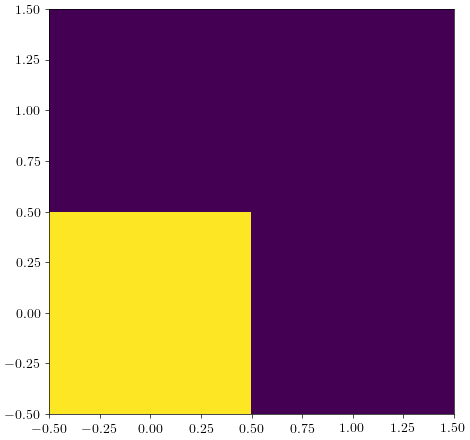

In [30]:
zeros = np.zeros((2, 2))

zeros[0][0] = 1

plot.plot(zeros)

In [31]:
i = 0

# loop over non-zero pixels, i.e. ignore pixels with no phonions
for x, y in tqdm(np.argwhere(mag_array != np.inf)):
    if i != 0:
        calc['scene'].append(build_default_source(geometry='point', telescope='roman'))

    # set brightness
    calc['scene'][i]['spectrum']['normalization']['norm_flux'] = mag_array[x][y]
    calc['scene'][i]['spectrum']['normalization']['norm_fluxunit'] = 'abmag'
    calc['scene'][i]['spectrum']['normalization']['norm_wave'] = norm_wave
    calc['scene'][i]['spectrum']['normalization']['norm_waveunit'] = 'microns'
    calc['scene'][i]['spectrum']['normalization']['type'] = 'at_lambda'

    # calculate position
    ra, dec = lens.pixel_grid.map_pix2coord(x=x, y=y)

    # set position
    calc['scene'][i]['position']['x_offset'] = dec  # NB lenstronomy's coordinate grid defines RA towards the positive y-axis (North) and DEC to the negative x-axis (East)
    calc['scene'][i]['position']['y_offset'] = ra  

    i += 1
print(f'Point source conversion complete: placed {i} point sources')

100%|██████████| 450/450 [00:03<00:00, 143.97it/s]

Point source conversion complete: placed 450 point sources


In [32]:
# do Pandeia calculation        
results, execution_time = pandeia_input.get_pandeia_results(calc)

pandeia_results = PandeiaOutput(results)

Performing Pandeia calculation...
Pandeia calculation complete


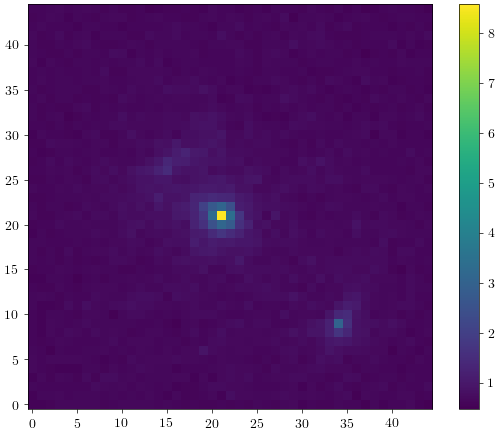

In [33]:
detector = pandeia_results.get_image()

plot.plot(detector, colorbar=True)